In [2]:
# Basics
import string
import numpy as np
import pandas as pd

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt

import re
from nltk.tokenize import TweetTokenizer

# Lectura de datos

In [3]:
df_train = pd.read_csv("../datos/training/EXIST2021_training.tsv", sep="\t")
df_test = pd.read_csv("../datos/test/EXIST2021_test.tsv", sep="\t")

df_train.shape, df_test.shape

((6977, 7), (4368, 5))

In [4]:
df_train.head()

,test_case,id,source,language,text,task1,task2
0,EXIST2021,1,twitter,en,"She calls herself ""anti-feminazi"" how about sh...",sexist,ideological-inequality
1,EXIST2021,2,twitter,en,"Now, back to these women, the brave and the be...",non-sexist,non-sexist
2,EXIST2021,3,twitter,en,"@CurvyBandida @Xalynne_B Wow, your skirt is ve...",sexist,objectification
3,EXIST2021,4,twitter,en,@AurelieGuiboud Incredible! Beautiful!But I l...,non-sexist,non-sexist
4,EXIST2021,5,twitter,en,i find it extremely hard to believe that kelly...,non-sexist,non-sexist


# Exploración de etiquetas

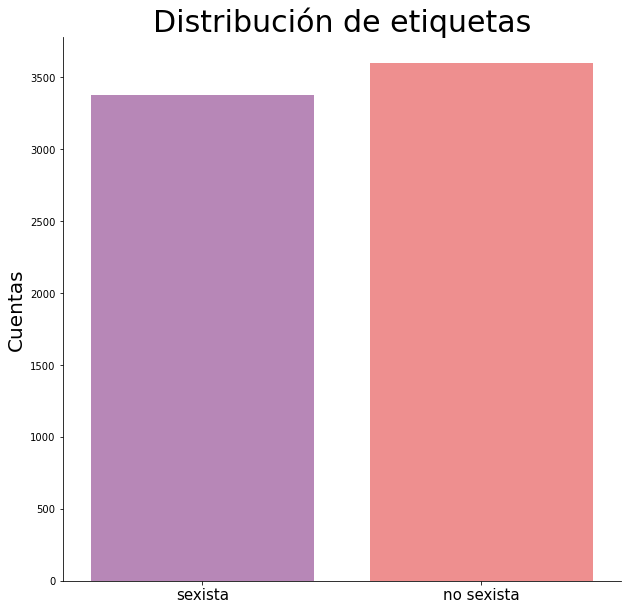

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
sns.countplot(data=df_train, x="task1", ax = ax, palette = ["purple", "red"], alpha = 0.5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_title("Distribución de etiquetas", fontsize = 30)
ax.set_xlabel("")
ax.set_ylabel("Cuentas", fontsize = 20)
ax.set_xticklabels(["sexista", "no sexista"], fontsize = 15)
fig.savefig("../figs/Dist.png", transparent = True, bbox_inches="tight")

Text(0, 0.5, 'Cuentas')

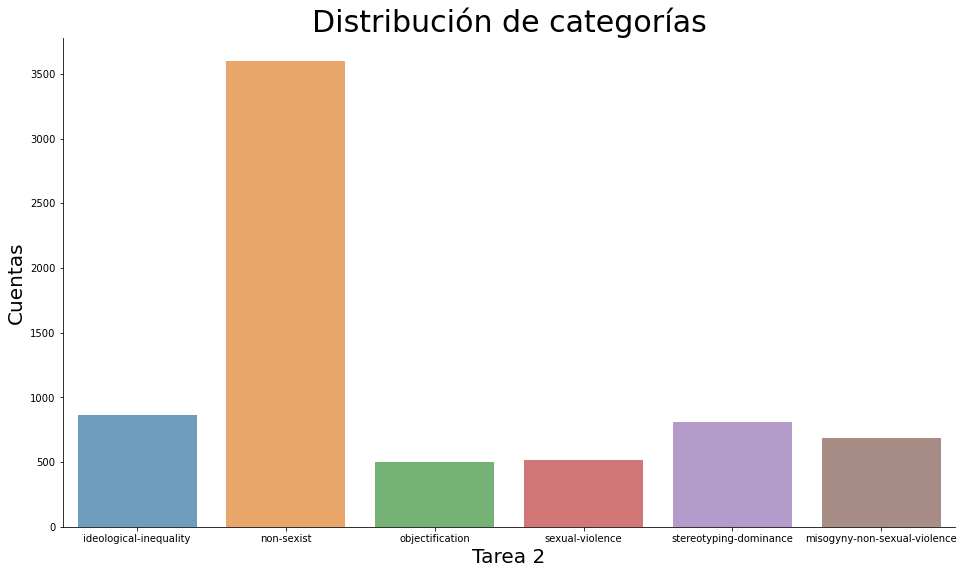

In [33]:
fig, ax = plt.subplots(figsize=(16,9))
sns.countplot(data=df_train, x="task2", ax=ax, alpha = 0.7)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_title("Distribución de categorías", fontsize = 30)
ax.set_xlabel("Tarea 2", fontsize = 20)
ax.set_ylabel("Cuentas", fontsize = 20)

# Exploración de fuente

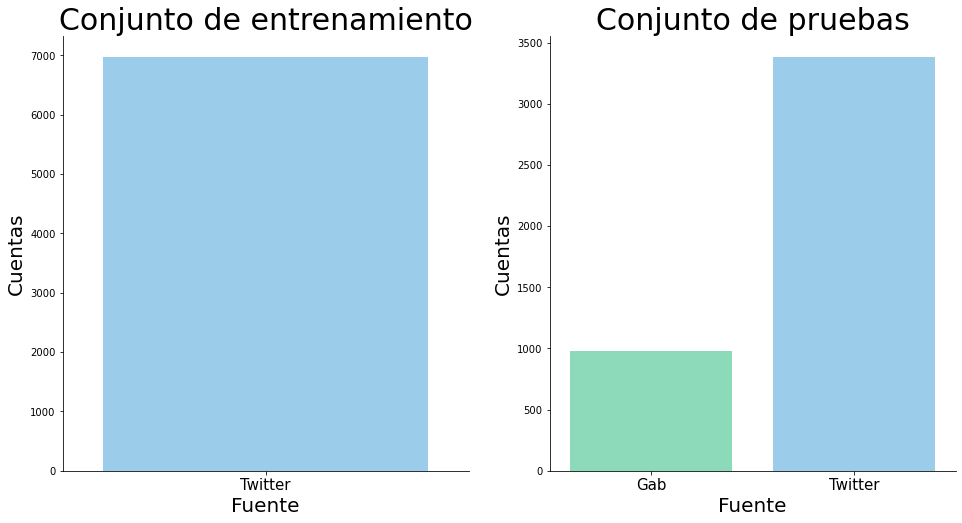

In [48]:
fig, ax = plt.subplots(figsize=(16,8), ncols=2)
sns.countplot(data=df_train, x="source", ax=ax[0], palette = ["#1DA1F2"], alpha = 0.5)
sns.countplot(data=df_test, x="source", ax=ax[1], palette = ["#00d17c", "#1DA1F2"], alpha = 0.5)

for i in range(2):
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["top"].set_visible(False)
    ax[i].set_xlabel("Fuente", fontsize = 20)
    ax[i].set_ylabel("Cuentas", fontsize = 20)

ax[0].set_title("Conjunto de entrenamiento", fontsize = 30)
ax[1].set_title("Conjunto de pruebas", fontsize = 30)
ax[0].set_xticklabels(["Twitter"], fontsize = 15)
ax[1].set_xticklabels(["Gab", "Twitter"] , fontsize = 15)
fig.savefig("../figs/Fuentes.png", transparent = True, bbox_inches="tight")

Lo que predomina es twitter. Respecto a los textos que vienen de gab, estos están en el conjunto de prueba, y dado que actualmente ya no tenemos manera de revisar como sería nuestro desempeño con dicho conjunto, podemos ignorarlos

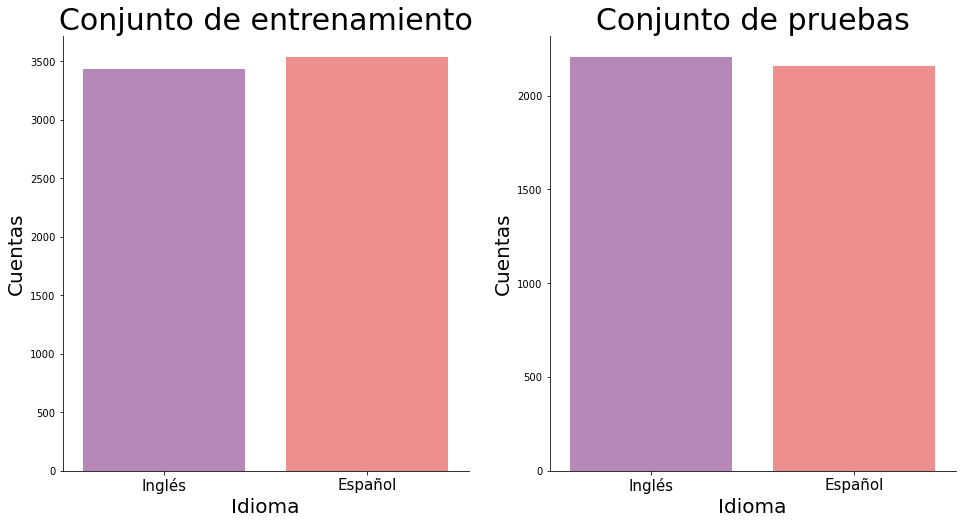

In [50]:
fig, ax = plt.subplots(figsize=(16,8), ncols=2)
sns.countplot(data=df_train, x="language", ax=ax[0], palette = ["purple", "red"], alpha = 0.5)
sns.countplot(data=df_test, x="language", ax=ax[1], palette = ["purple", "red"], alpha = 0.5)

for i in range(2):
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["top"].set_visible(False)
    ax[i].set_xlabel("Idioma", fontsize = 20)
    ax[i].set_ylabel("Cuentas", fontsize = 20)
    ax[i].set_xticklabels(["Inglés", "Español"], fontsize = 15)

ax[0].set_title("Conjunto de entrenamiento", fontsize = 30)
ax[1].set_title("Conjunto de pruebas", fontsize = 30)

fig.savefig("../figs/Idioma.png", transparent = True, bbox_inches="tight")

El conjunto de datos está balanceado en términos de los idiomas

# Preprocesamiento de tweets

* Todo minúsculas
* Sustituir usuarios con @usuario
* Con ayuda de TweetTokenizer(reduce_len), colapsar repeticiones
* Sustituir links

In [8]:
TweetTokenizer(reduce_len=True).tokenize("hola. .")

['hola', '. .']

In [9]:
def colapsar_repeticion(match):
    elemento = match.groups()
    assert len(match.groups()) == 1
    return elemento[0]

def procesar_tweet(tweet):
    tweet = tweet.lower()
    regex_usuario = re.compile(r"@[\w\d]+")
    tweet = regex_usuario.sub("@usuario", tweet)
    
    regex_link = re.compile(r"\b(?:https?://|www\.)\S+\b")
    tweet = regex_link.sub("<link>", tweet)
    
    regex_frac = re.compile(r"\d+/\d+\w*")
    tweet = regex_frac.sub("<número>", tweet)
    
    regex_numbers = re.compile(r"\d+\w*")
    tweet = regex_numbers.sub("<número>", tweet)
    
    tokenizer = TweetTokenizer(reduce_len=True)
    tokens = tokenizer.tokenize(tweet)
    
    regex_collapse = re.compile(r"(\w)\1{2}")
    
    tokens = [regex_collapse.sub(colapsar_repeticion, token) for token in tokens]
    
    simbolos = r"""'@¡"#$%&'()*+,-./:;<=>¿[\]^_`{|}~'"""
    simbolos = set(simbolos) | set(["--->", "...", ". . .", ". .", ". ...", ".."])
    tokens = [token for token in tokens if token not in simbolos]
    
    return tokens

def procesar_tweet_legado(tweet):
    tweet = tweet.lower()
    regex_usuario = re.compile(r"@[\w\d]+")
    tweet = regex_usuario.sub("@usuario", tweet)
    
    regex_link = re.compile(r"\b(?:https?://|www\.)\S+\b")
    tweet = regex_link.sub("<link>", tweet)
    
    tokenizer = TweetTokenizer(reduce_len=True)
    tokens = tokenizer.tokenize(tweet)
    
    regex_collapse = re.compile(r"(\w)\1{2}")
    
    tokens = [regex_collapse.sub(colapsar_repeticion, token) for token in tokens]
    
    simbolos = ""
    tokens = [token for token in tokens if token not in simbolos]
    
    return tokens

In [10]:
#tweet = df_train.loc[3, "text"]
tweet = r"Hooolaaaaa, estoy metiendo spam https://t.co/uvl5HhbmbR y aparte estoy saludando a @proplayer"
tweet

'Hooolaaaaa, estoy metiendo spam https://t.co/uvl5HhbmbR y aparte estoy saludando a @proplayer'

In [11]:
procesar_tweet(tweet)

['hola',
 'estoy',
 'metiendo',
 'spam',
 '<link>',
 'y',
 'aparte',
 'estoy',
 'saludando',
 'a',
 '@usuario']

In [12]:
tweet2 = r"""Hooola mi geentee. . hoy no les voy a poder dAr clase, les dejo mi eduflow ---> https://t.co/uvl5HhbmbR.
Por cierto @pobrediablo14, todavía no te pago las 26first 1/2 quincenas """

tweet2

'Hooola mi geentee. . hoy no les voy a poder dAr clase, les dejo mi eduflow ---> https://t.co/uvl5HhbmbR.\nPor cierto @pobrediablo14, todavía no te pago las 26first 1/2 quincenas '

In [13]:
procesar_tweet(tweet2)

['hola',
 'mi',
 'geentee',
 'hoy',
 'no',
 'les',
 'voy',
 'a',
 'poder',
 'dar',
 'clase',
 'les',
 'dejo',
 'mi',
 'eduflow',
 '<link>',
 'por',
 'cierto',
 '@usuario',
 'todavía',
 'no',
 'te',
 'pago',
 'las',
 '<número>',
 '<número>',
 'quincenas']

In [14]:
tweets = df_train["text"].apply(procesar_tweet)

In [15]:
tweets

0       [she, calls, herself, anti-feminazi, how, abou...
1       [now, back, to, these, women, the, brave, and,...
2       [@usuario, @usuario, wow, your, skirt, is, ver...
3       [@usuario, incredible, !, beautiful, !, but, i...
4       [i, find, it, extremely, hard, to, believe, th...
                              ...                        
6972    [estamos, igual, sin, pareja, pero, puedes, be...
6973                 [<número>, hijo, de, re, mil, putas]
6974    [seguramente, esta, chica, no, cobra, el, dine...
6975    [@usuario, mi, madre, dice, q, va, fea, y, i, ...
6976    [en, vuestras, casas, también, tenéis, esa, tr...
Name: text, Length: 6977, dtype: object